# LAB 3

In [5]:
from sklearn import clone
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.neural_network import BernoulliRBM
from matplotlib import pyplot as plt
from keras.datasets import mnist
from IPython.display import Image
import numpy as np
from sklearn.pipeline import Pipeline
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'

## 1. Proszę zademonstrować uczenie typu CD (Contrastive Divergence) pisząc procedury przejścia pomiędzy warstwą "wizualną" i ukrytą w sieci RBM. Następnie użyć tego mechanizmu do wyuczenia reprezentacji ukrytej z danych i wykorzystać tę reprezentację do przewidzenia wartości "wizualnej". Tego typu system nadaje się dobrze do tworzenia rekomendacji tj. znajdowania powiązań typu użytkownik-produkt zwiedzy o cząstkowych wyborach różnych produktów przez różnych użytkowników.

Let's image scenario when we have 3 customers, which buys only two types of books: fantasy and science-fiction.
We want to use CD to compute probability of them buying another book.

https://www.youtube.com/watch?v=Fkw0_aAtwIw

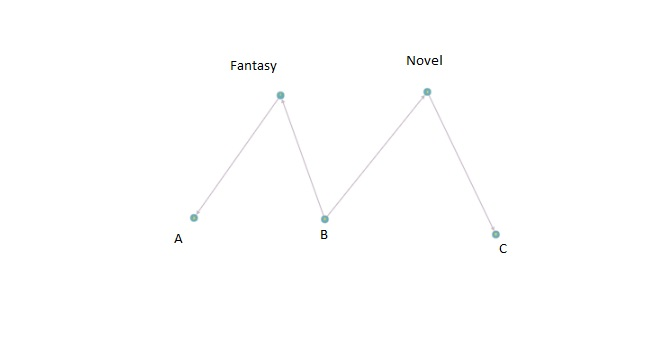

In [6]:
Image(filename='example.jpg')

## 2. Use RBM web ( own or use made from API scikit-learn) on some simple dataset (Mnist, Fashion Mnist, etc.) to:
-   show feature representation from CD learning
-   generate random examples
https://www.kaggle.com/nicw102168/restricted-boltzmann-machine-rbm-on-mnist
https://www.pyimagesearch.com/2014/06/23/applying-deep-learning-rbm-mnist-using-python/
https://www.kaggle.com/amitmeel1/restricted-bolztmann-machine-rbm/notebook

In [7]:
def load_digits(dataset_path: str) -> tuple:
	X = np.genfromtxt(dataset_path, delimiter = ",", dtype = "uint8")
	y = X[:, 0]
	X = X[:, 1:]
	return X, y

The BernoulliRBM assumes that the columns of our feature vectors fall within the range [0, 1].
However, the MNIST dataset is represented as unsigned 8-bit integers, falling within the range [0, 255].

To scale the columns into the range [0, 1], all we need to do is define a scale function:

In [8]:
def scale(x, eps = 0.001):
	return (x - np.min(x, axis = 0)) / (np.max(x, axis = 0) + eps)

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


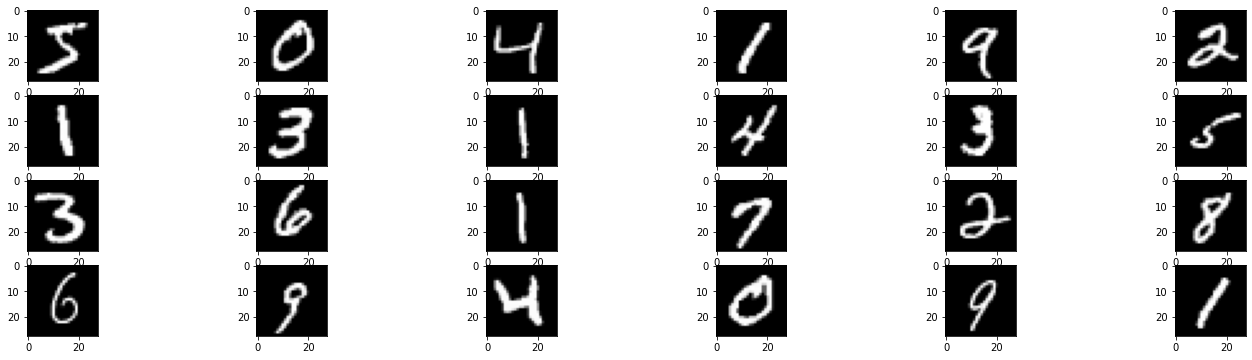

In [9]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))
fig, axs = plt.subplots(4, 6, figsize=(24, 6))
row = 0
for i in range(24):
    index = i % 6
    axs[row][index].imshow(train_X[i], cmap=plt.get_cmap('gray'))
    if index == 5:
        row = row + 1
plt.show()

In [10]:
train_X = train_X.astype("float32")
train_X = scale(train_X)
test_X = test_X.astype("float32")
test_X = scale(test_X)

In [11]:
nsamples, nx, ny = train_X.shape
train_X = train_X.reshape((nsamples,nx*ny))
nsamples, nx, ny = test_X.shape
test_X = test_X.reshape((nsamples,nx*ny))

In [12]:
class SimpleRBM:
    """A simple RBM example"""
    def __init__(self, iterations: int, lr0: float, components: int, verbose: bool = True):
        self.iterations = iterations
        self.lr0 = lr0
        self.components = components
        self.classifier = None
        self.verbose = verbose

    def train(self, train_x: np.ndarray, train_y: np.ndarray) -> None:
        self.classifier = BernoulliRBM(n_components = self.components, n_iter = self.iterations, learning_rate = self.lr0,  verbose = self.verbose)
        self.classifier.fit(train_x, train_y)

    def print_report(self, test_x: np.ndarray, test_y: np.ndarray) -> None:
        print(classification_report(test_y, self.classifier.predict(test_x)))

    def print_features(self) -> None:
        plt.figure(figsize=(20, 20))
        for i, comp in enumerate(self.classifier.components_):
            plt.subplot(10, 10, i + 1)
            plt.imshow(comp.reshape((28, 28)), cmap=plt.cm.RdBu, interpolation='nearest', vmin=-2.5, vmax=2.5)
            plt.axis('off')
            plt.suptitle('100 components extracted by RBM', fontsize=16)
        plt.show()

In [13]:
plt.rcParams['image.cmap'] = 'gray'

lr0 = 0.01
iterations = 100
components = 100

In [14]:
simpleRBM = SimpleRBM(iterations=iterations, lr0=lr0, components=components, verbose=True)

In [15]:
simpleRBM.train(train_X, train_y)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -112.90, time = 6.61s


KeyboardInterrupt: 

In [ ]:
simpleRBM.print_features()

In [ ]:
def gen_mnist_image(X):
    return np.rollaxis(np.rollaxis(X[0:200].reshape(20, -1, 28, 28), 0, 2), 1, 3).reshape(-1, 20 * 28)

In [ ]:
xx = train_X[:40].copy()
plt.figure(figsize=(10,20))
plt.imshow(gen_mnist_image(xx))
plt.show()

for ii in range(100):
    for n in range(40):
        xx[n] = simpleRBM.classifier.gibbs(xx[n])
plt.figure(figsize=(10,20))
plt.imshow(gen_mnist_image(xx))
plt.show()


## 3. Use any working DBN web (architecture, learning and example of problem to solve)

In [25]:
class SimpleDBN:
    """A simple RBM example"""
    def __init__(self, iterations: int, lr0: float, components: int, verbose: bool = True, batch_size: int = 100):
        self.iterations = iterations
        self.lr0 = lr0
        self.components = components
        self.classifier = None
        self.verbose = verbose
        self.batch_size = batch_size
        self.classifier = BernoulliRBM(n_components = self.components, n_iter = self.iterations, learning_rate = self.lr0,  verbose = self.verbose, batch_size=self.batch_size)
        self.logistic = LogisticRegression(C=100.0, solver='lbfgs', multi_class='multinomial', max_iter=self.iterations, verbose=self.verbose)
        self.model = Pipeline(steps=[('rbm', clone(self.classifier)), ('rbm2', clone(self.classifier)), ('clf', self.logistic)])

    def train(self, train_x: np.ndarray, train_y: np.ndarray) -> None:
        self.model.fit(train_x, train_y)

    def print_report(self, test_x: np.ndarray, test_y: np.ndarray) -> None:
        print(classification_report(test_y, self.model.predict(test_x)))

    def print_features(self) -> None:
        plt.figure(figsize=(20, 20))
        for i, comp in enumerate(self.model.components_):
            plt.subplot(10, 10, i + 1)
            plt.imshow(comp.reshape((28, 28)), cmap=plt.cm.RdBu, interpolation='nearest', vmin=-2.5, vmax=2.5)
            plt.axis('off')
            plt.suptitle('100 components extracted by RBM', fontsize=16)
        plt.show()

In [26]:
lr0 = 0.03
iterations = 150
components = 180
batch_size = 128

simpleDBM = SimpleDBN(iterations=iterations, lr0=lr0, components=components, verbose=True, batch_size=batch_size)

In [27]:
simpleDBM.train(train_X, train_y)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -145.01, time = 4.42s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -117.42, time = 5.73s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -109.65, time = 4.69s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -102.92, time = 4.85s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -97.45, time = 4.67s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -93.55, time = 4.40s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -91.71, time = 4.49s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -88.59, time = 5.30s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -86.32, time = 4.52s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -85.90, time = 4.60s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -84.05, time = 5.03s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -81.70, time = 5.40s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -81.66, time = 5.09s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -79.99, time = 5.14s
[BernoulliRBM] Iteration 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\pawst\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.9s finished


In [29]:
simpleDBM.print_report(test_X, test_y)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.95      0.95      0.95      1010
           4       0.97      0.97      0.97       982
           5       0.95      0.95      0.95       892
           6       0.97      0.98      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.95      0.96      0.96       974
           9       0.95      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

